# Covid-19 Fake News Detection
 

*   [Google Doc informatii generale](https://docs.google.com/document/d/1oVGBUXDLXlRHuM5gUXCFhZfhvTO1tIGL7-8b0IRrM7U/edit)



## Conectare Google Drive
Pentru a putea accesa dataset-ul folosind Drive, acesta va trebui descarcat si pus in locatia: `MyDrive/Colab Notebooks/Covid-19 Fake News Detection/dataset`

Exista si varianta de `wget` la inceputul notebook-ului, pentru a evita folosirea Google Drive (?)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Imports

In [ ]:
import os # OS path
import numpy as np # NumPy
import pandas as pd # Files read
import re # Regex for strings
from torch.utils.data import DataLoader, Dataset, RandomSampler
from collections import defaultdict
from typing import Dict, List
from torch import Tensor
import torch.nn.functional as F

## Citire date

In [ ]:
dataset_path = "/content/gdrive/MyDrive/Colab Notebooks/Covid-19 Fake News Detection/dataset/"

train_path = os.path.join(dataset_path, "covid_train.csv")
val_path = os.path.join(dataset_path, "covid_val.csv")

def citire_date(path, rows) -> pd.DataFrame:
  return pd.read_csv(path, delimiter = ',', nrows = rows)

train_dataset = citire_date(train_path, 6420)
val_dataset = citire_date(val_path, 2140)

print("*** Train ***")
print(train_dataset.head(10))
print(train_dataset.shape)
print("\n")

print("*** Validation ***")
print(val_dataset.head(10))
print(val_dataset.shape)

*** Train ***
   id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...  real
1   2  States reported 1121 deaths a small rise from ...  real
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4   5  Populous states can generate large case counts...  real
5   6  Covid Act Now found "on average each person in...  real
6   7  If you tested positive for #COVID19 and have n...  real
7   8  Obama Calls Trump’s Coronavirus Response A Cha...  fake
8   9  ???Clearly, the Obama administration did not l...  fake
9  10  Retraction—Hydroxychloroquine or chloroquine w...  fake
(6420, 3)


*** Validation ***
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mik

## Statistici

In [ ]:
def get_words_count(tweet):
  return len(re.split(' |,', tweet))

def get_chars_count(tweet):
  return len(tweet)

def get_urls_count(tweet):
  return len(re.findall(r'(?:https?:\/\/www|https?:\/\/|s?ftp:\/\/|www)', tweet))

def get_hashtag_cout(tweet):
  return len(re.findall('#',tweet))

dataset = train_dataset.append(val_dataset)
dataset_real = dataset[dataset['label'] == 'real']
dataset_fake = dataset[dataset['label'] == 'fake']

words_avg_real = np.vectorize(get_words_count)(dataset_real['tweet']).mean()
words_avg_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).mean()
print("Average words per real tweet: ", words_avg_real)
print("Average words per fake tweet: ", words_avg_fake, '\n')

chars_avg_real = np.vectorize(get_chars_count)(dataset_real['tweet']).mean()
chars_avg_fake = np.vectorize(get_chars_count)(dataset_fake['tweet']).mean()
print("Average chars per real tweet: ", chars_avg_real)
print("Average chars per fake tweet: ", chars_avg_fake, '\n')

urls_avg_real = np.vectorize(get_urls_count)(dataset_real['tweet']).mean()
urls_avg_fake = np.vectorize(get_urls_count)(dataset_fake['tweet']).mean()
print("Average URLs per real tweet: ", urls_avg_real)
print("Average URLs per fake tweet: ", urls_avg_fake, '\n')

hashtag_avg_real = np.vectorize(get_hashtag_cout)(dataset_real['tweet']).mean()
hashtag_avg_fake = np.vectorize(get_hashtag_cout)(dataset_fake['tweet']).mean()
print("Average hashtags per real tweet: ", hashtag_avg_real)
print("Average hashtags per fake tweet: ", hashtag_avg_fake, '\n')

max_words_real = np.vectorize(get_words_count)(dataset_real['tweet']).max()
max_words_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).max()
print("Maximum no. of words in a real tweet: ", max_words_real)
print("Maximum no. of words in a fake tweet: ", max_words_fake, '\n')

min_words_real = np.vectorize(get_words_count)(dataset_real['tweet']).min()
min_words_fake = np.vectorize(get_words_count)(dataset_fake['tweet']).min()
print("Minimum no. of words in a real tweet: ", min_words_real)
print("Minimum no. of words in a fake tweet: ", min_words_fake, '\n')

Average words per real tweet:  31.745982142857144
Average words per fake tweet:  21.87794117647059 

Average chars per real tweet:  215.37433035714287
Average chars per fake tweet:  143.51519607843136 

Average URLs per real tweet:  0.9419642857142857
Average URLs per fake tweet:  0.40980392156862744 

Average hashtags per real tweet:  1.0600446428571428
Average hashtags per fake tweet:  0.49950980392156863 

Maximum no. of words in a real tweet:  297
Maximum no. of words in a fake tweet:  1409 

Minimum no. of words in a real tweet:  3
Minimum no. of words in a fake tweet:  3 



In [ ]:
#number of unique words
import torch


def decontracted(phrase):
  #eliminate links
  phrase = re.sub(r"\S*https?:\S*", "", phrase) 
  
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase
  
new_dataset = []
for data in dataset['tweet']:
  element = decontracted(data)
  new_dataset.append(element)

def replace_punctuation(tweet):
  tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet.lower())
  return tweet

def split_tweet(tweet):
  tokens = tweet.split(" ")
  token_list = [x for x in tokens if x != '' and x!='https' and x!='http' and x!='s']
  return token_list

list_of_words = []
word_count = defaultdict(int)
for data in new_dataset:
  element = split_tweet(replace_punctuation(data))
  list_of_words.extend(element)

  
  # TODO: calculati frecventa de aparitie ale cuvintelor in dictionarul
  # word_count

print(list_of_words)

list_of_unique_words = list(set(list_of_words))

print("Number of unique words: " + str(len(list_of_unique_words)))


['the', 'cdc', 'currently', 'reports', '99031', 'deaths', 'in', 'general', 'the', 'discrepancies', 'in', 'death', 'counts', 'between', 'different', 'sources', 'are', 'small', 'and', 'explicable', 'the', 'death', 'toll', 'stands', 'at', 'roughly', '100000', 'people', 'today', 'states', 'reported', '1121', 'deaths', 'a', 'small', 'rise', 'from', 'last', 'tuesday', 'southern', 'states', 'reported', '640', 'of', 'those', 'deaths', 'politically', 'correct', 'woman', 'almost', 'uses', 'pandemic', 'as', 'excuse', 'not', 'to', 'reuse', 'plastic', 'bag', 'coronavirus', 'nashville', 'indiafightscorona', 'we', 'have', '1524', 'covid', 'testing', 'laboratories', 'in', 'india', 'and', 'as', 'on', '25th', 'august', '2020', '36827520', 'tests', 'have', 'been', 'done', 'profbhargava', 'dg', 'icmrdelhi', 'staysafe', 'indiawillwin', 'populous', 'states', 'can', 'generate', 'large', 'case', 'counts', 'but', 'if', 'you', 'look', 'at', 'the', 'new', 'cases', 'per', 'million', 'today', '9', 'smaller', 'stat

In [ ]:
#frequecy of words

#initialising
for word in list_of_unique_words:
  word_count[word] = 0


#counting
for word in list_of_words:
  word_count[word] += 1


print(word_count)
print(len(word_count))
print(len(list_of_unique_words))

defaultdict(<class 'int'>, {'diapers': 1, 'banks': 9, 'baptism': 1, '1197': 1, 'assertions': 1, '911': 2, 'beowulfschaefer': 1, 'rosewood': 1, 'orgies': 1, 'usd35': 1, 'graduated': 1, '81': 15, 'ethiopia': 3, 'cdctravelnotice': 2, 'warfare': 3, 'trvrb': 1, 'novakglobal': 1, 'insider': 1, 'compilation': 2, 'historical': 7, 'colds': 3, '175000': 1, 'kidnapped': 1, 'insurgency': 1, 'thereidout': 1, 'dem': 1, 'beer': 9, 'mazowiecki': 1, 'infant': 1, 'implement': 9, 'hoped': 1, 'stupid': 4, 'msomi': 1, 'document': 12, '298': 1, '1668': 1, 'maintenance': 1, 'fad': 2, 'kayleigh': 1, 'traces': 3, 'heneryhawk': 1, 'additional': 77, 'successive': 6, 'justice': 3, 'aspect': 1, 'relevant': 2, 'unaware': 1, 'birds': 2, 'tireless': 1, 'smoky': 1, 'insertion': 1, 'pin': 2, 'dharmis': 1, 'films': 2, 'implying': 2, '324': 1, 'irene': 1, 'submit': 1, 'oldies': 1, '110000': 4, 'pulled': 7, 'built': 12, 'each': 90, 'keep': 96, 'prostatitis': 1, 'chhattisgarh': 3, 'confidential': 1, 'affiliate': 4, 'gather

In [ ]:
class Vocabulary:
    """
    Vocabularul e un dictionar care ne tine corespondenta dintre cuvinte si
    indici unici. Fiecare cuvant are un indice unic => o propozitie devine
    o lista de indici.

    Reteaua va primii un tensor de dimensiune batch_size x max_timesteps, pe
    care il va da stratului de Embedding, care asociaza fiecarui cuvant un
    vector. Din stratul Embedding va rezulta un tensor de dimensiune:
      batch_size x max_timesteps x embedding_dim
    
    Daca avem urmatorul batch de 2 tweeturi:
    [[fake, news, everywhere, people, !],
     [masks, are, great]
    ], 
    atunci inputul nostru va fi un Tensor de dimensiune 2 x 5:
      x = torch.LongTensor([
        [32, 95, 13, 387, 88],
        [971, 18, 31, 0, 0]
      ]),
    unde 0 este indicele pentru tokenul special [PAD], pe care il appenduim la
    secventele mai scurte.
    """
    def __init__(self, word_count: Dict[str, int], min_freq: int):
        """
        word_count: dictionar cuvant -> frecventa cuvant in corpus 
                    (il puteti calcula acolo unde calculati si list_of_words)
        min_freq: frecventa minima de aparitie a unui cuvant; orice e sub
          il consideram token 'unknown' si il vom reprezenta cu '[UNK]'.
        """
        # [pad] e un token special pe care il appenduim la secventele mai scurte
        # dintr-un mini-batch
        # [unk] e un token pentru cuvinte necunoscute (de obicei cuvinte rare, 
        # cu frecventa mica, pe care o stabilim noi de obicei)
        self.word_to_idx = {'[pad]': 0, '[unk]':1}
        next_index = 2
        for word, freq in word_count.items():
            if freq >= min_freq:
                self.word_to_idx[word] = next_index
                next_index += 1
        
        # mapare inversa
        self.idx_to_char = {idx: word for (word, idx) in self.word_to_idx.items()}
   
    def size(self):
        return len(self.word_to_idx)
      
    def __str__(self):
        return str(self.word_to_idx)

# putem sa renuntam la cuvintele care apar de foarte putine ori in corpus
# si sa le reprezentam cu un token special 'unknown'
vocab = Vocabulary(word_count=word_count, min_freq=2)
print("Vocab size = ", vocab.size())

Vocab size =  8174


## Pre-procesarea datelor

In [ ]:
# import nltk
# nltk.download('stopwords')

# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))
# stop_words.add('is')

# Splitting data
train_data = []
for data in train_dataset["tweet"]:
  decontracted_data = decontracted(data)
  new_data = split_tweet(replace_punctuation(decontracted_data))
  # filtered_sentence = [w for w in new_data if not w in stop_words] 
  train_data.append(new_data)

# train_data = np.array(train_data)
print("Train data has been processed.")

validation_data = []
for data in val_dataset["tweet"]:
  decontracted_data = decontracted(data)
  new_data = split_tweet(replace_punctuation(decontracted_data))
  # filtered_sentence = [w for w in new_data if not w in stop_words] 
  validation_data.append(new_data)

# validation_data = np.array(validation_data)
print("Validation data has been processed.")


print(train_data[1])

Train data has been processed.
Validation data has been processed.
['states', 'reported', '1121', 'deaths', 'a', 'small', 'rise', 'from', 'last', 'tuesday', 'southern', 'states', 'reported', '640', 'of', 'those', 'deaths']


In [ ]:
class TweetDataset(Dataset):
    def __init__(self, 
                 tokenized_tweets: List[List[str]], 
                 labels: Tensor,
                 vocab: Vocabulary):
      """
      tokenized_tweets: lista de tweeturi deja sparte in cuvinte (la noi sunt 
      tinute in train_data/validation_data)
      labels: Tensor cu label-urile corecte din dataset
      vocab: vocabular
      """
      self.data = tokenized_tweets
      self.labels = labels
      self.vocabulary = vocab

    def __getitem__(self, index) -> (torch.Tensor, torch.Tensor):
      """
      index: indexul exemplului din setul nostru de date
      Functia reprezinta fiecare cuvant cu indicele corespunzator din Vocabular:
        ['wear', 'masks', '!'] => [31, 85, 422]

      Pentru exemplul de la pozitia `index`, intoarcem un Tensor cu 
      indicii cuvintelor sale si un Tensor cu label-ul aferent.
      """
      tweet_indices = []
      tweet = self.data[index]

      for word in tweet:
        if word in vocab.word_to_idx:
          tweet_indices.append(vocab.word_to_idx[word])
        else:
          tweet_indices.append(1)

      # print(tweet_indices)

      return torch.LongTensor(tweet_indices), torch.LongTensor([self.labels[index]])

    def __len__(self) -> int:
      return len(self.data)


In [ ]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-200')

# glove_model["beautiful"]

# Creating an empty Dictionary 
word2vector = {} 
words_without_vectors = [] #words without vector representation

#Creating the word to vector representation for our unique words

for word in list_of_unique_words:
  try:
    word2vector[word] = glove_model[word]
  except:
    words_without_vectors.append(word)

# word2vector: cuvant -> vector
# word2idx: cuvant -> indice

# Dataloader: batch_size x maxtimesteps

print(word2vector['currently'])
print(words_without_vectors)
print(len(words_without_vectors))

[==================================================] 100.0% 758.5/758.5MB downloaded
[ 2.2171e-01 -3.5923e-01  2.5812e-02 -6.6199e-01 -5.3659e-01 -1.4461e-01
  6.2618e-01 -3.0254e-01  8.0707e-02 -3.4064e-01 -4.3686e-01 -2.6997e-02
 -1.1086e+00 -3.0329e-02 -3.0697e-01  3.1967e-01  1.6875e-01  3.9496e-01
 -4.9079e-01 -5.1262e-02 -1.4728e-01 -3.0203e-01  9.9789e-02 -3.2287e-01
 -4.3984e-01  1.4741e+00 -5.5285e-02  3.8852e-01  2.2638e-01  5.2971e-01
  1.0884e-01 -4.3260e-03 -5.6306e-01 -4.0318e-01  1.4803e-01 -3.9840e-01
 -1.9454e-01 -4.6823e-02  3.2664e-01  1.1008e-01  7.3311e-01 -2.4409e-01
  5.4791e-02  4.8059e-01 -2.0711e-01 -4.4957e-01 -3.3600e-02 -9.0909e-02
 -7.4361e-01  3.7667e-02 -2.9519e-01  3.2866e-02 -3.9322e-01 -1.9890e-01
 -3.3682e-01  2.5899e-01 -4.0993e-01 -8.0254e-03  8.2972e-02  3.2001e-01
 -6.2119e-01  3.0065e-01 -2.5426e-01 -3.4844e-01  2.1544e-01  5.2369e-01
  2.3057e-01 -2.5343e-01  3.5474e-01 -1.4853e-01  3.7453e-01  4.3541e-01
  2.4713e-01 -5.1593e-01  2.4818e-01  1

In [ ]:
#Eliminate the words that have no representation

# !!! Ptr modelul neural n-as mai filtra cuvintele daca nu avem reprezentare 
# glove ptr ele; de exemplu apare destul de des 'covid', si am vrea sa
# invatam un embedding ptr el, nu sa-l ignoram

# for i in range(len(train_data)):
#   filtered_sentence = [w for w in train_data[i] if not w in words_without_vectors]
#   train_data[i] = filtered_sentence

# for i in range(len(validation_data)):
#   filtered_sentence = [w for w in validation_data[i] if not w in words_without_vectors]
#   validation_data[i] = filtered_sentence

#Replce the words with their vector representation and avarage
"""
no_vect_tweets = []
train_dataset_vectors = []
for i in range(len(train_data)):
  tweet2vector = []
  tweet = train_data[i]
 for word in tweet:
    tweet2vector.append(glove_model[word])
  if tweet2vector:
    train_data_vector= np.array(tweet2vector).mean(0)
    train_dataset_vectors.append(train_data_vector)
  else:
    no_vect_tweets.append(i)

train_dataset_vectors = torch.tensor(train_dataset_vectors)
train_batches = torch.split(train_dataset_vectors, 917, 0)

train_labels = []


train_labels_batches = torch.split(train_labels, 917, 0)

no_vect_val = []

validation_dataset_vectors = []
for i in range(len(validation_data)):
  tweet2vector = []
  tweet = validation_data[i]
  for word in tweet:
    tweet2vector.append(glove_model[word])
  if tweet2vector:
   validation_data_vector = np.array(tweet2vector).mean(0)
   validation_dataset_vectors.append(validation_data_vector)
  else:
    no_vect_val.append(i)

validation_dataset_vectors = torch.tensor(validation_dataset_vectors)
val_labels = []

"""

In [ ]:
train_labels = []
for i in range(len(train_dataset['label'])):
  label = train_dataset['label'][i]
  if label == "fake":
    train_labels.append(0)
  else:
    train_labels.append(1)

train_labels = torch.tensor(train_labels)

val_labels = []
for i in range(len(val_dataset['label'])):
  label = val_dataset['label'][i]
  if label == "fake":
    val_labels.append(0)
  else:
    val_labels.append(1)

val_labels = torch.tensor(val_labels)

In [ ]:
def collate_examples(batch_data):
    """
    Avem nevoie de aceasta functie in DataLoader pentru ca tweeturile
    noastre din batch au lungimi diferite si vrem sa le punem intr-un 
    singur tensor de dimensiune batch_size x max_timesteps

    Functia primeste o lista de tupluri (input, label) de lungime batch_size.
    input este un Tensor cu indicii cuvintelor dintr-un tweet 
    (asa cum e el intors de Dataset.__getitem__). label este un Tensor cu 1
    element (clasa corecta).

    De exemplu, daca avem urmatorul batch de 2 tweeturi:
      [[fake, news, everywhere, people, !],
       [masks, are, great]
      ], 
    atunci ele vor fi reprezentate ca o lista cu 2 Tensori:
        [torch.tensor([32, 95, 13, 387, 88],
         torch.tensor([971, 18, 31]),
        ]
    Noi trebuie sa calculam cea mai lunga secventa din batch (5 in exemplul de
    mai sus), sa cream un tensor de lungime batch_size x max_timesteps, pe
    care il umplem cu datele noastre, si la care appenduim '0' la tweeturile
    mai scurte. O sa ne rezulte:
       torch.tensor([[32, 95, 13, 387, 88],
                     [971, 18, 31, 0, 0]
                    ])
    De asemenea vom intoarce si un tensor de lungime batch_size, in care
    avem label-urile corecte pentru exemplele noastre
    """
    # lista cu tensori de lungime variabila
    batch_input = [e[0] for e in batch_data]
    #print("batch_input = ", batch_input)

    # lista cu Tensori cu 1 element (clasa corecta per exemplu)
    batch_labels = [e[1] for e in batch_data]
    #print("batch_labels = ", batch_labels)

    # TODO: calculati cel mai lung exemplu din batch_data
    max_len = max([len(example) for example in batch_input])

    batch_input_tensor = torch.zeros(len(batch_input), max_len).long()
    for idx, data in enumerate(batch_input):
        # TODO: copiati tensorul data in batch_tensor[idx]
        batch_input_tensor[idx, :data.size(0)] = data #torch.tensor(data)?

    # trebuie sa intoarcem si un tensor de dimensiune batch_size cu label-urile
    batch_labels_tensor = torch.cat(batch_labels)

    return (batch_input_tensor, batch_labels_tensor)


In [ ]:
train_dataset = TweetDataset(train_data, train_labels, vocab)
val_dataset = TweetDataset(validation_data, val_labels, vocab)

# RandomSampler ia elemente random din setul de date
sampler = RandomSampler(train_dataset)
sampler_val = RandomSampler(val_dataset)

# dataloader ne intoarce Tensori de dimensiune batch_size x max_timesteps
# daca nu ii specificam collate_fn, nu stie cum sa faca stack la un tweet de 
# lungime 10 si unul de lungime 15, de exemplu
dataloader = DataLoader(train_dataset, 
                        batch_size = 64, 
                        sampler = sampler,
                        collate_fn = collate_examples)

dataloader_val = DataLoader(val_dataset,
                            batch_size = 64,
                            sampler = sampler_val,
                            collate_fn = collate_examples)

In [ ]:
# acum putem sa iteram prin dataloader in for-ul de antrenare

# input are dimensiune batch_size x max_timesteps
# labels are dimensiune batch_size
for (input, labels) in dataloader:
    print(input)
    print(labels)
    break

tensor([[   1,    1,   74,  ...,    0,    0,    0],
        [3193, 1786, 2948,  ...,  530,    0,    0],
        [3939, 6036, 3779,  ..., 6140, 4897,  603],
        ...,
        [7787, 1862, 3725,  ...,    0,    0,    0],
        [5443, 4583, 3089,  ...,    0,    0,    0],
        [1221, 3362, 6331,  ...,    0,    0,    0]])
tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0])


In [ ]:
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from typing import Iterator

#Create the Network
class LSTMClassification(nn.Module):
  def __init__(self, 
              input_size: int,
              vocabulary: Vocabulary,
              vocabulary_size: int,
              hidden_size: int, 
              output_size: int,
              hidden_activation_fn,
              store_glove: bool):
      
      super().__init__()

      self.hidden_activation_fn = hidden_activation_fn
      # matricea de embeddings va fi initializata random
      self._embedding = nn.Embedding(vocabulary_size, input_size)
      
      if store_glove:
        # TODO
        # pentru cuvintele din vocabular pentru care avem vectori Glove,
        # vom copia vectorul in matrice pe randul corespunzator cuvantului
        # noi o sa fine-tunam si layer-ul asta, asa ca si pentru cuvintele
        # pentru care nu aveam features din Glove, vom invata niste reprezentari
        # din datele noastre (de exemplu 'covid', care nu are vector Glove,
        # dar care apare destul de des in dataset si pare un cuvant important)

        # iterez prin tot vocab 
        # are reprezentare => weight append vector
        # self._embedding.weight = ...

        weights = torch.empty((vocabulary_size, 200))
        for (index, word) in vocab.idx_to_char.items():
          try:
            weights[index] = torch.Tensor(word2vector[word])
          except:
            weights[index] = torch.randn(200)
        
        self._embedding = nn.Embedding.from_pretrained(weights)

      # else:
          # vom invata vectori pentru cuvinte doar din datele noastre

      self._lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
      self._layer1 = nn.Linear(hidden_size, hidden_size)
      self._layer2 = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
      # x: batch_size x max_timesteps
      # [[Ana, are, mere] => [[1, 65, 32],
      # [[Ei, danseaza]]  => [[31, 47, 0]]

      # use h_n for classification
      # batch_size x max_timesteps x input_size (200)
      x_embedding = self._embedding(x)

      output, (h_n, c_n) = self._lstm(x_embedding)
      hn_output = self._layer1(h_n.squeeze())
      output2 = self._layer2(self.hidden_activation_fn(hn_output))

      return output2

class MLPNN(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 hidden_activation_fn = nn.Tanh()):
      
        super().__init__()

        self._layer1 = nn.Linear(input_size, hidden_size)
        self._layer2 = nn.Linear(hidden_size, output_size)

        self._hidden_activation = hidden_activation_fn
   
    def forward(self, x):

        h = self._hidden_activation(self._layer1(x))
        out = self._layer2(h)
        
        return out

In [ ]:
from matplotlib import pyplot as plt
def plot_metrics(metrics1, metrics2, label1, label2):
    """
    Plots 2 metrics on same graph
    :param metrics1: array 
    :param metrics2: array 
    :param label1: array 
    :param label2: array 

    """
    plt.figure()
    plt.plot(metrics1, c='b', label=label1)
    plt.plot(metrics2, c='g', label=label2)
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Start MLPNN

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#Train the model
model = MLPNN(200, 200, 2)

NUM_EPOCHS = 150

train_loss = []
val_loss = [] # This time we will track the loss on val_data
val_acc = []
val_prec = []
val_recall = []
val_f1 = []

#optim = torch.optim.Adam(model.parameters(), lr=0.001)
optim = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

batch_id = 0
for i in range(NUM_EPOCHS):
    # Set the model to train mode and reset the gradients
    model.train()
    optim.zero_grad()

    output = model(train_batches[batch_id])
    target = torch.tensor(train_labels_batches[batch_id])
    loss = criterion(output, target)
    
    loss.backward()
    optim.step()
    
    train_loss.append(loss.detach().numpy())

    print(f'\nEPOCH {i}:')
    print(f'\nBatch {batch_id}')
    print(f'loss = {loss.item()}')

    model.eval() # set the model to evaluation mode
    with torch.no_grad():
        output = model(validation_dataset_vectors)
        validation_loss = F.cross_entropy(output, val_labels)
        print(f'validation loss {validation_loss}')
        val_loss.append(validation_loss)

    predicted = np.array(torch.argmax(model(validation_dataset_vectors), dim=-1))

    print("predicted = ", predicted)
    print("val_labels = ", val_labels)
    accuracy = (predicted==np.array(val_labels)).sum()/predicted.shape[0]
    print(f'Validation accuracy {accuracy}')

    predicted_tensor = torch.tensor(predicted)

    precision = precision_score(val_labels, predicted_tensor)
    print(f'Validation precision {precision}')

    recall = recall_score(val_labels, predicted_tensor)
    print(f'Validation recall {recall}')

    f1 = f1_score(val_labels, predicted_tensor)
    print(f'Validation F1 {f1}')

    if batch_id >= 6:
      batch_id = 0
    else:
      batch_id += 1
  
    # # store validation metrics
    val_acc.append(accuracy)
    val_prec.append(precision)
    val_recall.append(recall)
    val_f1.append(f1)

NameError: ignored

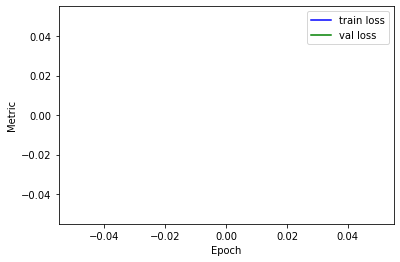

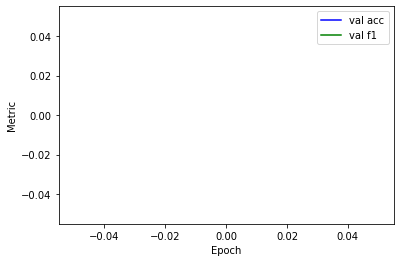

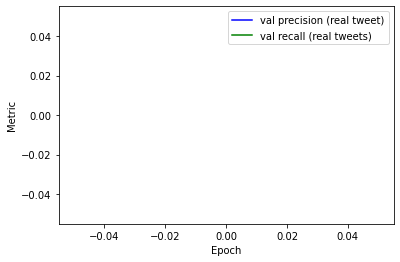

In [ ]:
plot_metrics(train_loss, val_loss, 'train loss', 'val loss')
plot_metrics(val_acc, val_f1, 'val acc', 'val f1')
plot_metrics(val_prec, val_recall, 'val precision (real tweet)', 'val recall (real tweets)')

In [ ]:
len(val_labels)
sum(val_labels)
sum(predicted)

NameError: ignored

# End MLPNN

# Start LSTM

In [ ]:
def train(model, data_loader, optim, criterion):
    
    # Set the model to train mode and reset the gradients
    model.train()

    train_loss_batch = []
    for batch_id, (batch_data, batch_labels) in enumerate(data_loader):
      optim.zero_grad()
      
      # batch_size x 256 hidden_size
      output = model(batch_data)

      # print(output.size())
      # print(batch_labels.size())
      loss = criterion(output, batch_labels)
      
      loss.backward()
      optim.step()
    
      train_loss_batch.append(loss.detach().numpy())

      print(f'\nTrain batch: {batch_id}')
      print(f'Train loss = {loss.item()}')

    return np.array(train_loss_batch).mean()

In [ ]:
def validate(model, data_loader):

    # set the model to evaluation mode
    model.eval()

    val_loss_batch = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    for batch_id, (batch_data, batch_labels) in enumerate(data_loader):
      with torch.no_grad():
          # TODO: append predictii in lista pentru tot setul de validare
          output = model(batch_data)
          validation_loss = F.cross_entropy(output, batch_labels)
          print(f'\nValidation batch: {batch_id}')
          print(f'Validation loss: {validation_loss}')
          val_loss_batch.append(validation_loss)

          predicted = np.array(torch.argmax(model(batch_data), dim=-1))

          accuracy = accuracy_score(predicted, batch_labels)
          accuracies.append(accuracy)

          precision = precision_score(predicted, batch_labels)
          precisions.append(precision)

          recall = recall_score(predicted, batch_labels)
          recalls.append(recall)

          f1 = f1_score(predicted, batch_labels)
          f1s.append(f1)

    # print("predicted = ", predicted)
    # print("val_labels = ", val_labels)
    
    loss = np.array(val_loss_batch).mean()
    accuracy = np.array(accuracies).mean()
    precision = np.array(precisions).mean()
    recall = np.array(recalls).mean()
    f1 = np.array(f1s).mean()

    return loss, accuracy, precision, recall, f1


EPOCH: 0

Train batch: 0
Train loss = 0.6931207180023193

Train batch: 1
Train loss = 0.8846664428710938

Train batch: 2
Train loss = 0.7037514448165894

Train batch: 3
Train loss = 0.7124108672142029

Train batch: 4
Train loss = 0.7174659371376038

Train batch: 5
Train loss = 0.6663221716880798

Train batch: 6
Train loss = 0.7028102278709412

Train batch: 7
Train loss = 0.6780946254730225

Train batch: 8
Train loss = 0.6957075595855713

Train batch: 9
Train loss = 0.6883108615875244

Train batch: 10
Train loss = 0.69529128074646

Train batch: 11
Train loss = 0.6940284967422485

Train batch: 12
Train loss = 0.7029675841331482

Train batch: 13
Train loss = 0.6878019571304321

Train batch: 14
Train loss = 0.6981799602508545

Train batch: 15
Train loss = 0.6963117122650146

Train batch: 16
Train loss = 0.6930234432220459

Train batch: 17
Train loss = 0.6855177283287048

Train batch: 18
Train loss = 0.7141140699386597

Train batch: 19
Train loss = 0.6997972726821899

Train batch: 20
Train

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Streaming output truncated to the last 5000 lines.

Validation batch: 22
Validation loss: 0.35916903614997864

Validation batch: 23
Validation loss: 0.1442985236644745

Validation batch: 24
Validation loss: 0.22898869216442108

Validation batch: 25
Validation loss: 0.15421977639198303

Validation batch: 26
Validation loss: 0.1382957249879837

Validation batch: 27
Validation loss: 0.19927935302257538

Validation batch: 28
Validation loss: 0.5448951125144958

Validation batch: 29
Validation loss: 0.09044241905212402

Validation batch: 30
Validation loss: 0.2838265895843506

Validation batch: 31
Validation loss: 0.1793542504310608

Validation batch: 32
Validation loss: 0.2023230642080307

Validation batch: 33
Validation loss: 0.2971147894859314

Validation loss for epoch 12: 0.2617824673652649

Validation accuracy for epoch 12: [0.48391544117647056, 0.7662158613445378, 0.8375787815126051, 0.8718487394957983, 0.8772977941176471, 0.8944984243697478, 0.90953256302521, 0.9194459033613446, 0.9

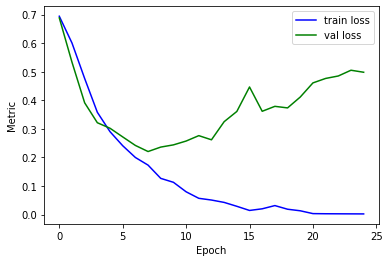

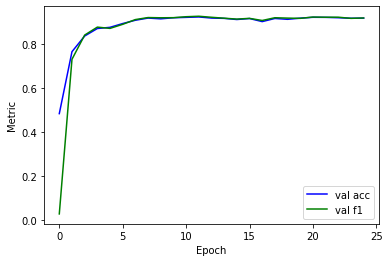

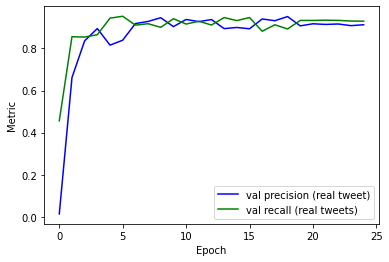

In [ ]:
model = LSTMClassification(200, vocab, vocab.size(), 256, 2, nn.Tanh(), True)
# optim = torch.optim.SGD(model.parameters(), lr=0.1)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 25

train_loss = []
val_loss = []
val_acc = []
val_prec = []
val_recall = []
val_f1 = []

for i in range(epochs):
  print(f'\nEPOCH: {i}')
      
  train_loss_epoch = train(model, dataloader, optim, criterion)
  train_loss.append(train_loss_epoch)
  print(f'\nTrain loss for epoch {i}: {train_loss_epoch}')
  
  val_loss_epoch, val_acc_epoch, val_prec_epoch, val_rec_epoch, val_f1_epoch = validate(model, dataloader_val)
  val_loss.append(val_loss_epoch)
  val_acc.append(val_acc_epoch)
  val_prec.append(val_prec_epoch)
  val_recall.append(val_rec_epoch)
  val_f1.append(val_f1_epoch)
  print(f'\nValidation loss for epoch {i}: {val_loss_epoch}')
  print(f'\nValidation accuracy for epoch {i}: {val_acc_epoch}')

print(f'\nAverage train loss: {np.array(train_loss).mean()}')
print(f'\nAverage validation loss: {np.array(val_loss).mean()}')

plot_metrics(train_loss, val_loss, 'train loss', 'val loss')
plot_metrics(val_acc, val_f1, 'val acc', 'val f1')
plot_metrics(val_prec, val_recall, 'val precision (real tweet)', 'val recall (real tweets)')